##### Importing Necessary Libraries

In [8]:
import os
import cv2
import torch.nn.functional as F
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF
import torch
from torch.utils.data._utils.collate import default_collate
import torch.nn as nn
import torch.optim as optim

Loading the paths of the dataset. Dataset consists of train images, train labels , test images and test labels. 

In [2]:
train_images_path = 'train-20241028T084108Z-001/train/images'
train_labels_path = 'labels_train-20241027T221052Z-001/labels_train'
test_images_path = 'test-20241028T083722Z-001/test/images'
test_labels_path = 'labels_test-20241027T221048Z-001/labels_test'
annotations_map = {}
detections_map = {}

The annotaions_map dictionary contains the ground the truth of the images and the detections_map dictionary stores the predicted bounding boxes and labels. 

In [3]:
import os
import xml.etree.ElementTree as ET
def parse_annotations_xml(labels_dir):
    annotations = {}
    for xml_file in os.listdir(labels_dir):
        xml_path = os.path.join(labels_dir, xml_file)
        parsed_tree = ET.parse(xml_path)
        root_element = parsed_tree.getroot()
        img_name = root_element.find('filename').text
        img_objects = []
        for obj_elem in root_element.findall('object'):
            class_name = obj_elem.find('name').text
            bbox_elem = obj_elem.find('bndbox')
            x_min = int(bbox_elem.find('xmin').text)
            y_min = int(bbox_elem.find('ymin').text)
            x_max = int(bbox_elem.find('xmax').text)
            y_max = int(bbox_elem.find('ymax').text)
            img_objects.append({'class': class_name, 'bbox': [x_min, y_min, x_max, y_max]})
        annotations[img_name] = img_objects
    return annotations

The above function goes through each file of XML files and these files are parsed using ElementTree. And this function takes filename, class and bounding box coordinates. And these are stored in form a dictionary in image objects list. Then these are stored in annotations_map dictionary. 

In [4]:
class DetectionDataset(Dataset):
    def __init__(self, img_dir, lbls_dir, transform):
        self.img_dir = img_dir
        self.annotations_dict = parse_annotations_xml(lbls_dir)
        self.transform = transform
        self.img_filenames = list(self.annotations_dict.keys())  
    def __len__(self):
        return len(self.img_filenames)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_filenames[index])
        img = Image.open(img_path).convert("RGB")
        bounding_boxes = []
        class_names = [] 
        for obj in self.annotations_dict[self.img_filenames[index]]:
            bounding_boxes.append(obj['bbox'])
            class_names.append(obj['class'])  
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        if self.transform:
            img, bounding_boxes = self.transform(img, bounding_boxes)
        data_sample = {'img': img, 'bboxes': bounding_boxes, 'class_names': class_names, 'img_filename': self.img_filenames[index]}
        return data_sample

The parse_annotations_xml function loads the data and len function will return the length and the getitem function retrieves annotations and images and converts bounding boxes to tensors. 

##### Perform necessary data transformation and augmentation steps

In [5]:
def resize_image_and_boxes(img, bboxes, output_size=(640, 640)):
    orig_w, orig_h = img.size
    resized_img = TF.resize(img, output_size)
    img_tensor = TF.to_tensor(resized_img)
    new_w, new_h = output_size
    if bboxes.nelement() == 0:
        return img_tensor, torch.empty((0, 4), dtype=torch.float32)
    scale_x, scale_y = new_w / orig_w, new_h / orig_h
    resized_bboxes = bboxes * torch.tensor([scale_x, scale_y, scale_x, scale_y], dtype=torch.float32)
    return img_tensor, resized_bboxes
def custom_collate(batch):
    imgs_batch = [item['img'] for item in batch]
    bboxes_batch = [item['bboxes'] for item in batch]
    img_filenames_batch = [item['img_filename'] for item in batch]
    class_names_batch = [item['class_names'] for item in batch]
    imgs = torch.utils.data.default_collate(imgs_batch)
    filenames = torch.utils.data.default_collate(img_filenames_batch)
    return {'img': imgs, 'bboxes': bboxes_batch, 'img_filename': filenames, 'class_names': class_names_batch}
train_data = DetectionDataset(train_images_path, train_labels_path, transform=resize_image_and_boxes)
test_data = DetectionDataset(test_images_path, test_labels_path, transform=resize_image_and_boxes)
train_split_ratio = 0.8
train_data_size = int(train_split_ratio * len(train_data))
val_data_size = len(train_data) - train_data_size
train_split, val_split = random_split(train_data, [train_data_size, val_data_size])
train_loader = DataLoader(train_split, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_split, batch_size=4, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, collate_fn=custom_collate)
print("Training images:", [train_split[i]['img_filename'] for i in range(3)])
print("Validation images:", [val_split[i]['img_filename'] for i in range(3)])
print("Test images:", [test_data[i]['img_filename'] for i in range(3)])

Training images: ['road483_png.rf.b977146fe2dae193bf71ce8c61a6fcee.jpg', 'road80_png_jpg.rf.b93792e043bac01806e1283c03990d87.jpg', 'War_Memorial-_Maryburgh_-_geograph-org-uk_-_4092270_jpg.rf.3e9925c0b503662feaad624eec903192.jpg']
Validation images: ['road595_png.rf.56a42c9ee6433d2c81789c6f30930c19.jpg', 'road303_png.rf.0ead2957c33ffda958afbc278ba9c39b.jpg', 'road396_png.rf.886502eb1b471594cfad1c31c0b826e6.jpg']
Test images: ['00000_00000_00018_png_jpg.rf.f707cbdaf4d44b31e41ee7d604b558de.jpg', '00000_00000_00019_png_jpg.rf.0caa91836417583be08013d5f095bcdc.jpg', '00000_00000_00021_png_jpg.rf.76273d6def41e680b11585baf2c5060f.jpg']


##### Plot some random images from the train, test, and validation set

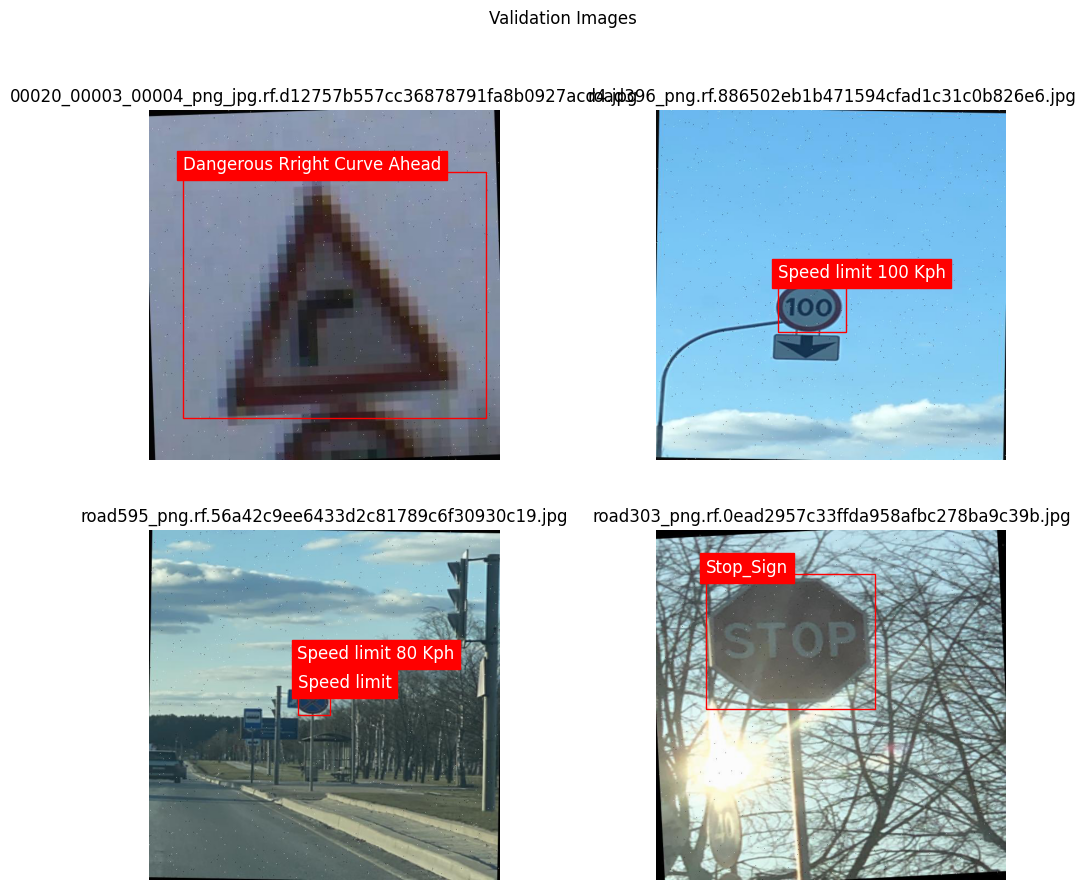

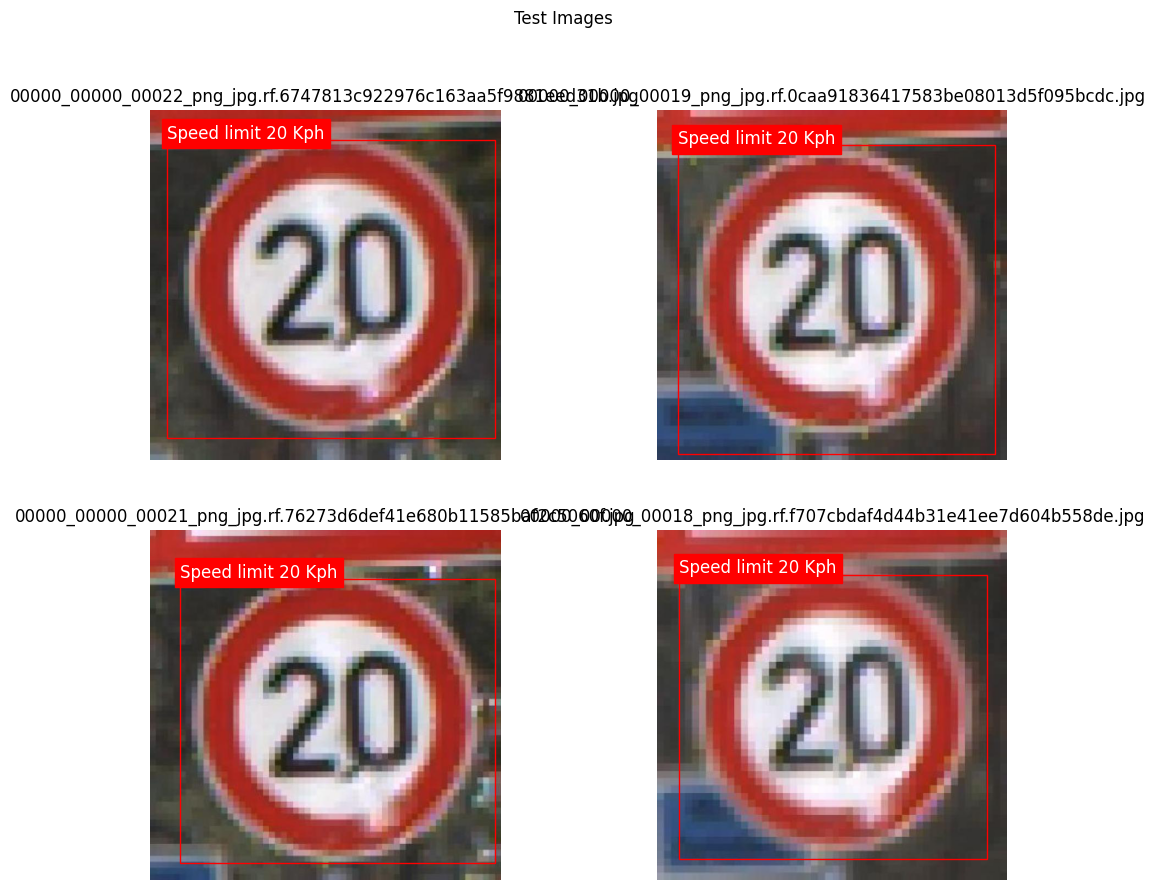

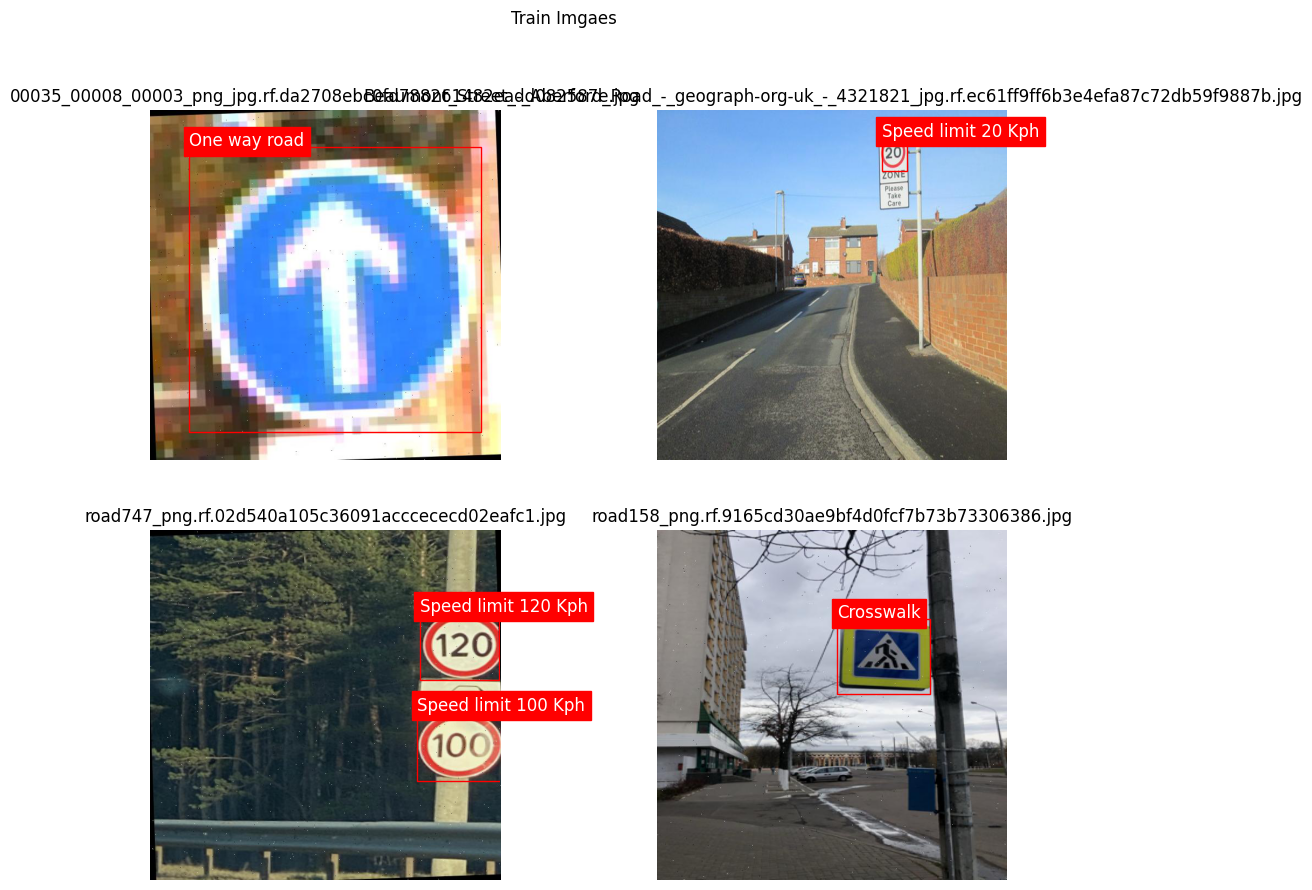

In [6]:
def display_images_with_bboxes(data_loader, title, num_samples=4):
    batch_data = next(iter(data_loader))
    imgs, bboxes, img_filenames, class_names = batch_data['img'], batch_data['bboxes'], batch_data['img_filename'], batch_data['class_names']
    selected_indices = torch.randperm(len(imgs))[:num_samples]
    num_rows = np.ceil(num_samples / 2).astype(int)
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
    fig.suptitle(title)
    for i, idx in enumerate(selected_indices):
        row = i // 2
        col = i % 2
        img_np = imgs[idx].numpy().transpose((1, 2, 0))
        bbox_data = bboxes[idx].numpy()
        img_filename = img_filenames[idx]
        class_name = class_names[idx]
        if num_rows > 1:
            axis = axes[row, col]
        else:
            axis = axes[col]
        axis.imshow(img_np)
        for bbox, label in zip(bbox_data, class_name):  
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            axis.add_patch(rect)
            axis.text(bbox[0], bbox[1] - 2, label, color='white', fontsize=12, backgroundcolor='red')
        axis.set_title(img_filename)
        axis.axis('off')
    plt.show()
display_images_with_bboxes(val_loader, 'Validation Images')
display_images_with_bboxes(test_loader, 'Test Images')
display_images_with_bboxes(train_loader, 'Train Imgaes')

##### Pick one model of your choice and implement it from scratch to perform object detection.

In [7]:
class BasicObjectDetector(nn.Module):
    def __init__(self):
        super(BasicObjectDetector, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc_layer1 = nn.Linear(64 * 80 * 80, 512)
        self.fc_layer2 = nn.Linear(512, 4)  

    def forward(self, inputs):
        x = F.max_pool2d(F.relu(self.conv_layer1(inputs)), 2)
        x = F.max_pool2d(F.relu(self.conv_layer2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv_layer3(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_layer1(x))
        x = self.fc_layer2(x)
        return x
def adjusted_mse_loss(predictions, targets, padding_val=-1):
    total_loss = 0.0
    valid_samples = 0
    for idx, target_boxes in enumerate(targets):
        if target_boxes.nelement() == 0:
            continue  
        pred_boxes = predictions[idx]  
        valid_target_box = target_boxes[0].to(device).unsqueeze(0) 
        total_loss += F.mse_loss(pred_boxes.unsqueeze(0), valid_target_box, reduction='mean')
        valid_samples += 1
    average_loss = total_loss / valid_samples if valid_samples > 0 else torch.tensor(0.0, requires_grad=True)
    return average_loss
def train_detector(detector_model, train_data_loader, val_data_loader, optim, epochs=50):
    detector_model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data in train_data_loader:
            input_imgs = batch_data['img'].to(device)  
            target_boxes = batch_data['bboxes']
            optim.zero_grad()
            preds = detector_model(input_imgs)
            batch_loss = adjusted_mse_loss(preds, target_boxes)
            batch_loss.backward()
            optim.step()
            epoch_loss += batch_loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss / len(train_data_loader)}")
        validation_loss = 0.0
        detector_model.eval()  
        with torch.no_grad():
            for batch_data in val_data_loader:
                input_imgs = batch_data['img'].to(device)  
                target_boxes = batch_data['bboxes']
                preds = detector_model(input_imgs)
                batch_loss = adjusted_mse_loss(preds, target_boxes)
                validation_loss += batch_loss.item()
        detector_model.train()  
        print(f"Validation Loss: {validation_loss / len(val_data_loader)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicObjectDetector().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_detector(model, train_loader, val_loader, optimizer, epochs=50)

Epoch 1, Training Loss: 10542.53617794413
Validation Loss: 5796.653360774008
Epoch 2, Training Loss: 5271.3028017429115
Validation Loss: 6490.248877593194
Epoch 3, Training Loss: 3449.6932924010944
Validation Loss: 3393.35962759868
Epoch 4, Training Loss: 1929.0891550198407
Validation Loss: 2199.5579519664752
Epoch 5, Training Loss: 1139.1645800953181
Validation Loss: 4239.139847887589
Epoch 6, Training Loss: 863.7677034942197
Validation Loss: 2486.200826637754
Epoch 7, Training Loss: 658.9310585559253
Validation Loss: 2085.702646434084
Epoch 8, Training Loss: 610.5376564742254
Validation Loss: 1348.4855084365672
Epoch 9, Training Loss: 686.8290322496298
Validation Loss: 1650.2788584276977
Epoch 10, Training Loss: 418.58566223287806
Validation Loss: 1184.535427765007
Epoch 11, Training Loss: 371.71115505594605
Validation Loss: 1701.7149449037702
Epoch 12, Training Loss: 484.00190391361434
Validation Loss: 1374.7009929699843
Epoch 13, Training Loss: 374.6686157907119
Validation Loss: 10

##### Compute the IOU of your results with the test set and print a few predicted images

Average IoU: 0.587
Accuracy: 0.787


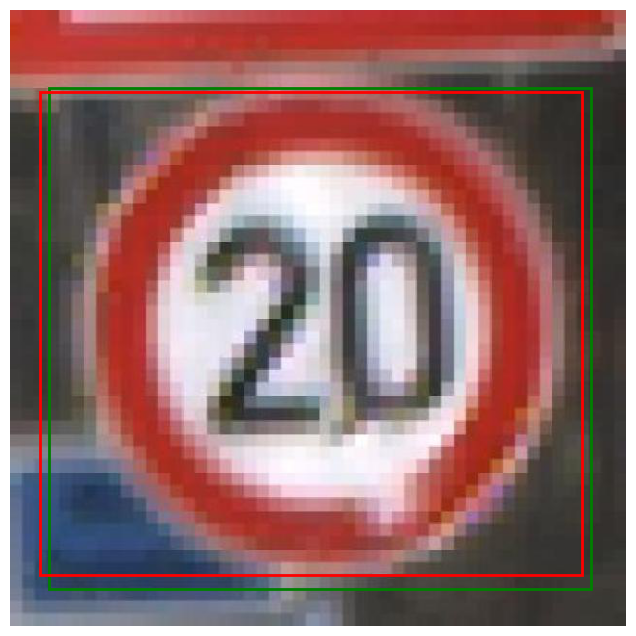

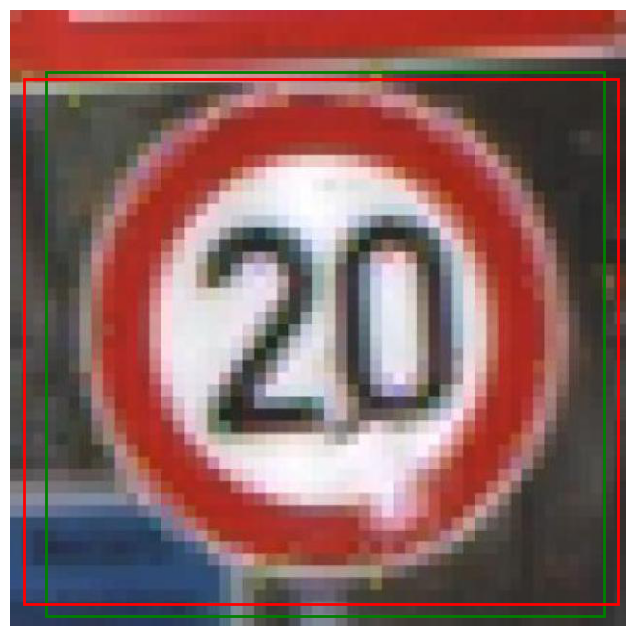

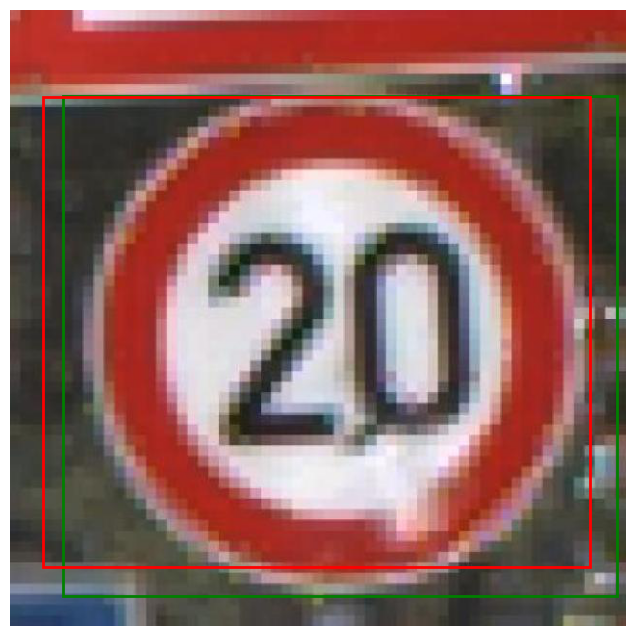

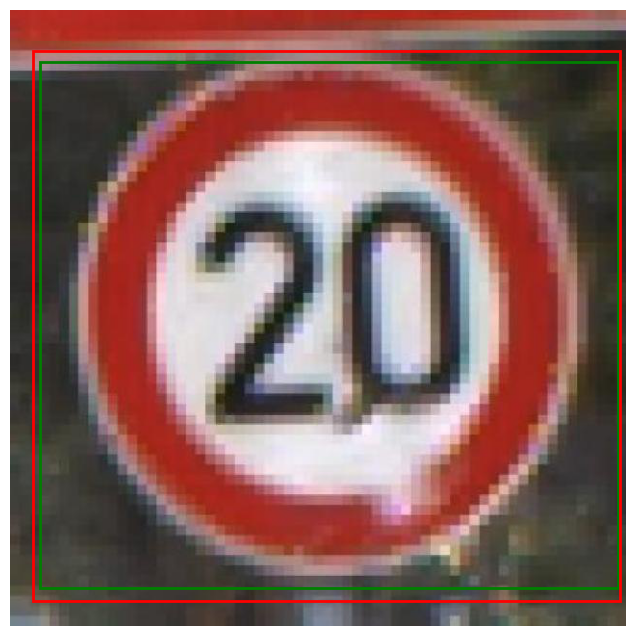

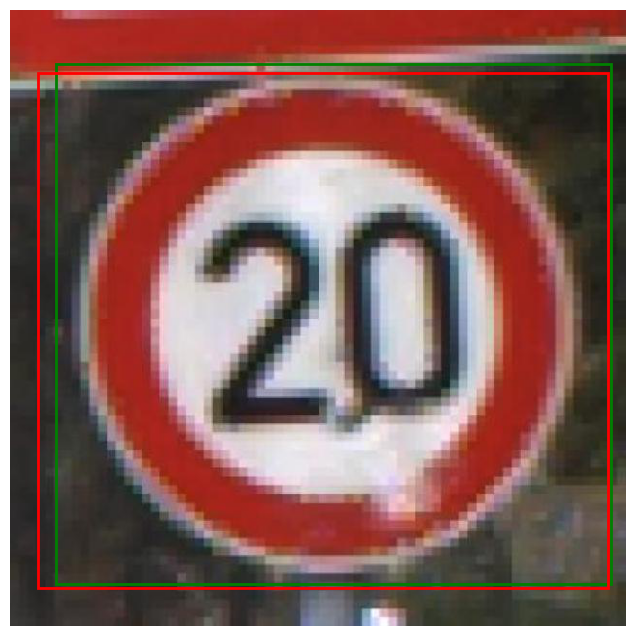

In [11]:
def calculate_iou(bbox1, bbox2):
    x1 = torch.max(bbox1[0], bbox2[0])
    y1 = torch.max(bbox1[1], bbox2[1])
    x2 = torch.min(bbox1[2], bbox2[2])
    y2 = torch.min(bbox1[3], bbox2[3])
    intersection_area = torch.max(torch.tensor(0.0), x2 - x1) * torch.max(torch.tensor(0.0), y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = bbox1_area + bbox2_area - intersection_area
    iou = intersection_area / union_area
    return iou
def evaluate_detector(detector_model, data_loader, iou_thresh):
    detector_model.eval()  
    cumulative_iou = 0.0
    accurate_detections = 0
    total_detections = 0
    with torch.no_grad():
        for batch in data_loader:
            batch_images = batch['img'].to(device)
            ground_truth_boxes = batch['bboxes']  
            pred_boxes = detector_model(batch_images)  
            for pred_bbox, gt_boxes in zip(pred_boxes, ground_truth_boxes):
                if gt_boxes.nelement() == 0:  
                    continue
                max_iou = 0  
                for gt_box in gt_boxes:
                    iou = calculate_iou(pred_bbox, gt_box).item()
                    max_iou = max(max_iou, iou)
                cumulative_iou += max_iou
                if max_iou >= iou_thresh:
                    accurate_detections += 1
                total_detections += 1 if max_iou > 0 else 0
    avg_iou = cumulative_iou / total_detections if total_detections > 0 else 0
    detection_accuracy = accurate_detections / total_detections if total_detections > 0 else 0
    return avg_iou, detection_accuracy
avg_iou, detection_accuracy = evaluate_detector(model, test_loader, 0.25)
print(f"Average IoU: {avg_iou:.3f}")
print(f"Accuracy: {detection_accuracy:.3f}")
def visualize_and_save_detections(image, ground_truth_boxes, pred_boxes, img_name, display=True):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    img_np = image.detach().cpu().numpy().transpose((1, 2, 0))
    ax.imshow(img_np)
    for bbox in ground_truth_boxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    for bbox in pred_boxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f"{img_name}"), bbox_inches='tight')
    if display:
        plt.show()  
    plt.close()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval() 
num_images_to_display = 5
output_dir = '/app/custom_predictions/predicted_images'
os.makedirs(output_dir, exist_ok=True)
predicted_boxes_dir = '/app/custom_predictions/predicted_image_boxes'
os.makedirs(predicted_boxes_dir, exist_ok=True)
for i, batch in enumerate(test_loader):
    batch_images = batch['img'].to(device)
    ground_truth_boxes = batch['bboxes']
    pred_boxes = model(batch_images) 
    img_names = batch['img_filename'] 
    batch_size = batch_images.size(0)  
    for j in range(batch_size):  
        display = i * batch_size + j < num_images_to_display  
        img_name = img_names[j]
        pred_box_file_path = os.path.join(predicted_boxes_dir, img_name.replace('.png', '.txt'))
       
        with open(pred_box_file_path, 'w') as f:
            for pred in pred_boxes:
                bbox_data = pred.detach().cpu().numpy().tolist()
                f.write(f'{bbox_data}\n')
                annotations_map[img_name] = [bbox_data]
        visualize_and_save_detections(batch_images[j].cpu(), ground_truth_boxes[j], pred_boxes[j].unsqueeze(0).cpu().detach().numpy(), img_name, display=display)

In [12]:
torch.save(model.state_dict(), 'custom_model_weights.pth')

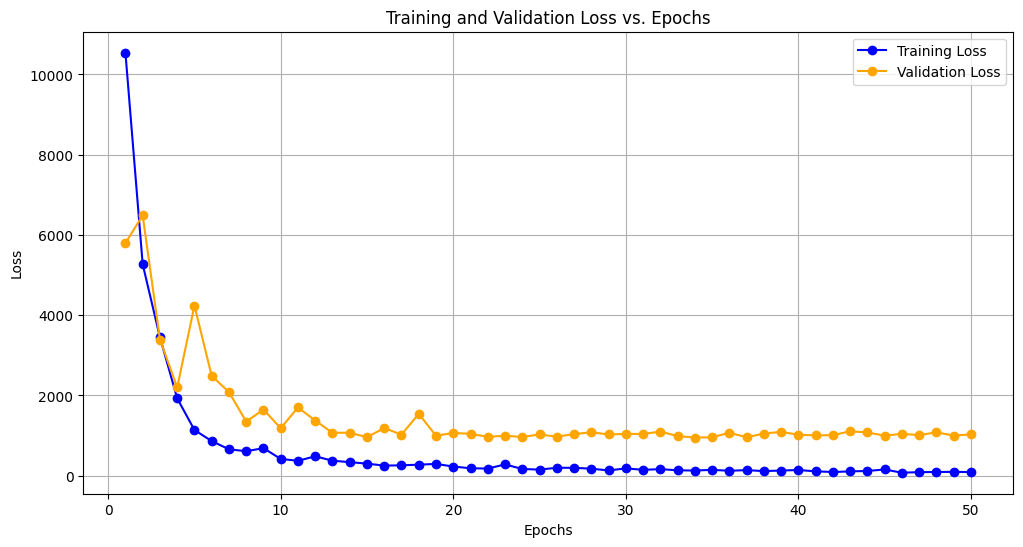

In [13]:
import matplotlib.pyplot as plt
epochs = list(range(1, 51))
train_loss = [
    10542.53617794413, 5271.3028017429115, 3449.6932924010944, 1929.0891550198407, 1139.1645800953181,
    863.7677034942197, 658.9310585559253, 610.5376564742254, 686.8290322496298, 418.58566223287806,
    371.71115505594605, 484.00190391361434, 374.6686157907119, 337.6870372539395, 301.5030502140242,
    251.65464803310627, 259.4159661754196, 275.1602335791073, 294.0655152979031, 229.12286216843296,
    185.81499311599373, 178.796049347282, 281.09557293457607, 168.58820502321484, 151.89288489919312,
    198.19665036716373, 197.19896489891087, 174.97124202352174, 131.93869843953092, 182.30090420951305,
    147.03206491425564, 163.92597520765565, 135.11481968248395, 128.44611961740844, 146.788728994271,
    123.07725960861349, 139.71958783288517, 115.2768199526648, 128.94990497732385, 141.7464532270118,
    109.5337020229286, 92.35067285752632, 107.98647468459438, 118.18688741692915, 155.9950293258882,
    74.66374909933744, 88.86362441425592, 92.18891521686679, 96.37652773163128, 90.66571896781385
]
val_loss = [
    5796.653360774008, 6490.248877593194, 3393.35962759868, 2199.5579519664752, 4239.139847887589,
    2486.200826637754, 2085.702646434084, 1348.4855084365672, 1650.2788584276977, 1184.535427765007,
    1701.7149449037702, 1374.7009929699843, 1069.3842032786165, 1072.322592345963, 960.0063479991442,
    1189.323861054267, 1023.7682100074568, 1542.6828481267007, 996.3699464690819, 1065.484388244286,
    1045.1167894856314, 969.6360446629899, 996.3105507468463, 965.1458215320602, 1027.4386182349274,
    973.2328405344531, 1036.7491117041657, 1083.8056300588314, 1028.2991474308772, 1042.224432513062,
    1039.7793955285003, 1100.2615388020147, 988.5712941344758, 952.103125411473, 957.0275812184766,
    1071.3514063974444, 957.6558496996705, 1049.8251436497835, 1093.3987856518463, 1021.9054833029986,
    1004.4422312532918, 1011.4228808227996, 1107.310152689616, 1078.5901392675964, 998.4638822605548,
    1043.2710736449737, 1012.7979470156552, 1080.7165191878987, 1000.8947065260527, 1028.9323779331164
]
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label="Training Loss", color='blue', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='orange', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()